In [50]:
import datetime
import os
import random
from collections.abc import Iterable
from math import ceil

import plotly.express as px
import plotly.graph_objects as go
import plotly.io
import polars as pl
import polars.selectors as cs
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [51]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [52]:
random.seed(57)
tf.random.set_seed(57)

plotly.io.templates.default = "plotly_dark"

In [53]:
# TODO Fourier analysis and correlations -> different notebook

In [54]:
# folder containing the inputs from the competition
INPUT_DIR = os.path.abspath("input")

In [55]:
# TODO move all constants to the beginning

TARGET_LENGTH = 16  # length of the target sequences

# metadata columns = [items on promotion, oil prices, weekday]
METADATA_COLS = ["onpromotion", "dcoilwtico", "weekday"]
FEATURES = 1 + len(METADATA_COLS)  # number of input features

DATAFRAMES_TIMESTEPS = 600  # number of timesteps to keep in the training dataframe
TRAIN_RATIO = 0.8  # ratio of data to use for training vs for validation
TRAIN_TIMESTEPS = int(DATAFRAMES_TIMESTEPS * TRAIN_RATIO)
VALID_TIMESTEPS = DATAFRAMES_TIMESTEPS - TRAIN_TIMESTEPS

In [56]:
# training hyperparameters
LEARNING_RATE = 1e-4  # TODO adjust?
BATCH_SIZE = 64

# buffer size for dataset shuffling
BUFFER_SIZE = 10_000

# the Kaggle competition uses Root Mean Squared Logarithmic Error
LOSS = tf.keras.losses.MeanSquaredLogarithmicError()

---
# Data preparation

In [57]:
def fill_missing_dates(df: pl.DataFrame) -> pl.DataFrame:
    """Adds the missing dates and fills the missing values."""

    date_df = pl.DataFrame(
        pl.date_range(
            df["date"].min(), df["date"].max(), interval="1d", eager=True
        ).alias("date")
    )

    df = date_df.join(
        df,
        on="date",
        how="outer",
    ).drop("date_right")

    # interpolate and fill backward/forward in case the first/last value is missing
    df = df.interpolate().fill_null(strategy="backward").fill_null(strategy="forward")

    return df

In [58]:
# read and complete the dataframe containing the oil prices
oil_df = pl.read_csv(os.path.join(INPUT_DIR, "oil.csv"), try_parse_dates=True)
oil_df = fill_missing_dates(oil_df)

In [59]:
# read the training dataframe
train_df = pl.read_csv(os.path.join(INPUT_DIR, "train.csv"), try_parse_dates=True)
train_df = train_df.drop("id")  # we do not need the id

# keep only the chosen number of timesteps plus TARGET_LENGTH steps to use as test set
train_df = train_df.filter(
    pl.col("date")
    > train_df["date"].max() - datetime.timedelta(DATAFRAMES_TIMESTEPS + TARGET_LENGTH)
)

# partition the training data into dataframes for each (store_nbr, family) pair
dataframes = train_df.partition_by(
    ["store_nbr", "family"], include_key=False, as_dict=True
)

# fill missing dates and add oil prices and weekday signal to each dataframe
for key, df in dataframes.items():
    dataframes[key] = (
        fill_missing_dates(df)
        .join(oil_df, on="date", how="inner")
        .with_columns(pl.col("date").dt.weekday().alias("weekday"))
        .with_columns(cs.numeric().cast(pl.Float32))  # cast numeric columns to Float32
    )

In [65]:
# Create test dataframes to evaluate our models after training
# The test dataframes simulate the targets (from test.csv), except that
# we have the values of the 'sales' column (to compare with our predictions).

test_dataframes = {}

# use the last TARGET_LENGTH timesteps of each dataframe as test set
for key, df in dataframes.items():
    test_dataframes[key] = df.tail(TARGET_LENGTH)
    dataframes[key] = df.head(-TARGET_LENGTH)

In [66]:
print("columns:", dataframes[key].columns)
print("training dataframes shape:", dataframes[key].shape)
print("test dataframes shape    :", test_dataframes[key].shape)

columns: ['date', 'sales', 'onpromotion', 'dcoilwtico', 'weekday']
training dataframes shape: (600, 5)
test dataframes shape    : (16, 5)


In [67]:
# TODO Only need to add the values from test.csv for the predictions, not for training
# NOTE call 'target_df' to avoid confusion with the test dataframes (taken from train.csv)

# target_df = pl.read_csv(os.path.join(INPUT_DIR, "test.csv"), try_parse_dates=True)

# # Add a 'sales' column filled with null values to the test dataframe
# target_df = target_df.with_columns(pl.lit(None).alias("sales")).select(train_df.columns)

# # Concatenate the dataframes so that the training dataframe contains all time steps
# train_df = pl.concat([train_df, target_df])

---
# Filtering

In [68]:
# NOTE zero-tail series
# filter out all series having their tail uniformly zero

ZERO_TAIL_LENGTH = 16

zero_tail_dataframes = {
    key: df
    for key, df in dataframes.items()
    if df.tail(ZERO_TAIL_LENGTH).select("sales").sum().item() == 0
}

for key in zero_tail_dataframes.keys():
    _ = dataframes.pop(key)

print("drop:", len(zero_tail_dataframes), "| remaining:", len(dataframes))

drop: 116 | remaining: 1666


In [238]:
%%script echo skipping

# plot a random series with zero-tail
df = zero_tail_dataframes[random.sample(sorted(zero_tail_dataframes.keys()), 1)[0]]
px.line(data_frame=df, x="date", y="sales")

skipping


In [70]:
# NOTE series with gaps
# filter out all series having a gap of at least `GAP_LENGTH` timesteps (= 0)

# minimum gap length
GAP_LENGTH = 32

gap_dataframes = {
    key: df
    for key, df in dataframes.items()
    if df.with_columns(pl.col("sales").rolling_mean(window_size=GAP_LENGTH))[
        "sales"
    ].min()
    == 0.0
}

for key in gap_dataframes.keys():
    _ = dataframes.pop(key)

print("drop:", len(gap_dataframes), "| remaining:", len(dataframes))

drop: 188 | remaining: 1478


In [239]:
%%script echo skipping

# plot a random series with a gap
df = gap_dataframes[random.sample(sorted(gap_dataframes.keys()), 1)[0]]
px.line(data_frame=df, x="date", y="sales")

skipping


In [240]:
%%script echo skipping

# plot a random series from the remaining keys
df = dataframes[random.sample(sorted(dataframes.keys()), 1)[0]]
px.line(data_frame=df, x="date", y="sales")

skipping


---
# MODEL DEFINITION
---

In [77]:
# NOTE Notation:
# NOTE - S = sales
# NOTE - M = (M_1, M_2, ...) = vector of metadata variables
# NOTE - Z(t) = value of variable Z at timestep t

# NOTE Ansatz: there exists a random variable X which underlies S
# NOTE in the sense that S = f(X, M) for some function f.

# NOTE We consider windows (sequences of consecutive timesteps) composed of N+T timesteps
# NOTE and split into two parts
# NOTE (t_(-N-1), ..., t_0) of N = input_length timesteps   ->  x-window (xW)
# NOTE (t_1, ..., t_T)      of T = TARGET_LENGTH timesteps  ->  y-window (yW)
#
# NOTE We have the values of all metadata variables on the entire window and the values of S on the x-window.
# NOTE We want to predict the values of S on the y-window.

# NOTE We proceed in three steps:
# NOTE 1. DECOUPLING: extract the value of the underlying variable X on the x-window from those of S and M
# NOTE   {S(t), M(t) : t in xW} -> {X(t) : t in xW}
# NOTE 2. TIME SERIES PREDICTION: predict the values of X on the y-window from its values on the x-window
# NOTE   {X(t) : t in xW} -> {X(t) : t in yW}
# NOTE 3. COUPLING: combine X with the metadata to obtain the values of S on the y-window
# NOTE   {X(t), M(t) : t in yW} -> {S(t) : t in yW}
# NOTE Each arrow represents a neural network and takes the values of the previous network as input.
#
# NOTE The process can be summarized as:
# NOTE [S(xW), M(xW)] -> |DECOUPNET| -> X(xW) -> |TIMENET| -> X(yW) -> [X(yW), M(yW)] -> |COUPNET| -> S(yW)

# NOTE We will use dense models to do the coupling/decoupling and try different architectures for the TS prediction.

In [78]:
# NOTE Create decoupling/coupling networks to use in all models.
# NOTE We choose simple architectures under the assumption that the coupling relation
# NOTE (the function f above) is not very complicated.

decoupling_net = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(None, FEATURES)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
    ],
    name="DecoupNet",
)

coupling_net = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(TARGET_LENGTH, FEATURES)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
    ],
    name="CoupNet",
)

In [307]:
def make_model(timenet: tf.keras.Model, name: str) -> tf.keras.Model:
    # create instances of the decoupling/coupling networks to use in the model
    dcnet = tf.keras.models.clone_model(decoupling_net)
    cnet = tf.keras.models.clone_model(coupling_net)

    # variable names are in the form `window_var`
    x_win = tf.keras.Input(shape=(None, FEATURES), name="x-window")
    y_m = tf.keras.Input(shape=(TARGET_LENGTH, FEATURES - 1), name="y-metadata")

    x_x = dcnet(x_win)
    y_x = timenet(x_x)
    y_xm = tf.keras.layers.Concatenate(axis=-1, name="y-concat")([y_x, y_m])
    y_s = cnet(y_xm)

    model = tf.keras.Model(inputs=[x_win, y_m], outputs=y_s, name=name)

    model.compile(
        loss=LOSS, optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    )

    return model

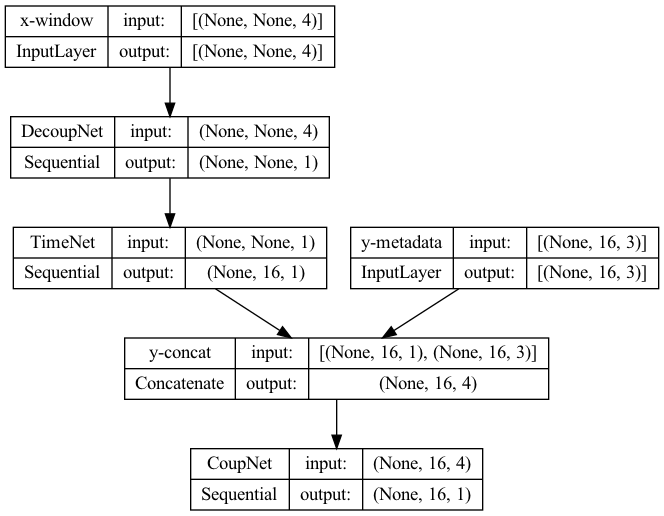

In [312]:
# make a dummy TimeNet to illustrate the architecture
dummy_timenet = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(None, 1)),
        tf.keras.layers.Lambda(lambda xs: xs[-TARGET_LENGTH:]),
        tf.keras.layers.Reshape((TARGET_LENGTH, 1)),
    ],
    name="TimeNet",
)

dummy_model = make_model(dummy_timenet, name="dummy")

tf.keras.utils.plot_model(dummy_model, show_shapes=True)

---
# DATASET CREATION
---

In [338]:
# NOTE A window is window_length = input_length + TARGET_LENGTH timesteps of consecutive data from a dataframe.
# NOTE Each window produces one (input, target) pair, where
# NOTE - target = y-window metadata
# NOTE - input = (x-window, y-window metadata)

# NOTE For a single key, the number of windows is window_count = TIMESTEPS - window_length + 1.
# NOTE The total number of elements in the dataset is thus ceil(window_count * len(keys) / BATCH_SIZE).

# NOTE Having `batch` before `map` gives a marginal performance increase
# NOTE see https://www.tensorflow.org/guide/data_performance
# NOTE verified in practice

In [340]:
class KeysDataset(tf.data.Dataset):
    @tf.function
    def _split_batch_window(window: tf.Tensor):
        # split window into x-window and y-window - keep the batches
        x_win = window[:, :-TARGET_LENGTH]
        y_win = window[:, -TARGET_LENGTH:]

        y_s = tf.gather(y_win, indices=[0], axis=-1)
        y_m = tf.gather(y_win, indices=[1, 2, 3], axis=-1)

        return (x_win, y_m), y_s

    def _generator(window_length: int, window_count: int, xs: tf.Tensor):
        for key_ind in range(xs.shape[0]):
            for window_ind in range(window_count):
                yield xs[key_ind, window_ind : window_ind + window_length]

    def __new__(cls, input_length: int, keys: Iterable[tuple[int, str]], train: bool):
        # window_length = input_length + TARGET_LENGTH
        # window_count = (
        #     (TRAIN_TIMESTEPS if train else VALID_TIMESTEPS) - window_length + 1
        # )

        dfs = [dataframes[key].select(["sales"] + METADATA_COLS) for key in keys]

        if train:
            dfs = [df.head(TRAIN_TIMESTEPS) for df in dfs]
        else:
            dfs = [df.tail(VALID_TIMESTEPS) for df in dfs]

        window_length = input_length + TARGET_LENGTH
        window_count = len(dfs[0]) - window_length + 1
        window_spec = tf.TensorSpec(shape=(window_length, FEATURES), dtype=tf.float32)

        # concatenate all data into one tensor -> (keys, timesteps, features)
        xs = tf.concat([tf.expand_dims(df, 0) for df in dfs], axis=0)

        ds = tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=window_spec,
            args=(window_length, window_count, xs),
        )

        return (
            ds.batch(BATCH_SIZE)
            .map(cls._split_batch_window, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
        )

In [344]:
class KeysDatasets:
    def __init__(self, input_length: int, keys: Iterable[tuple[int, str]]):
        self.train = KeysDataset(input_length, keys, train=True)
        self.valid = KeysDataset(input_length, keys, train=False)

        # compute the number of batches in the datasets
        window_length = input_length + TARGET_LENGTH
        train_windows = TRAIN_TIMESTEPS - window_length + 1
        valid_windows = VALID_TIMESTEPS - window_length + 1

        self.train_batches = ceil(train_windows * len(keys) / BATCH_SIZE)
        self.valid_batches = ceil(valid_windows * len(keys) / BATCH_SIZE)

    @property
    def length(self) -> dict[str, int]:
        return {"train": self.train_batches, "valid": self.valid_batches}

In [ ]:
# NOTE Note on the train/valid split of the resulting datasets
#
# NOTE Because of how the windowing works, the 80/20 split chosen at the start is
# NOTE far from what we obtain for the train/valid datasets.
# NOTE The number of windows in a dataset decreases linearly with the input lenght,
# NOTE for instance for 600 timesteps (480 train/120 valid) and an input length of 96,
# NOTE the number of windows (per key) is 369/9, which is a 41/1 split.
#
# NOTE This is particulary noticeable for input lengths close to the number of validation
# NOTE timesteps, as this leaves very few validation windows.

---
# MODEL SELECTION
---

In [196]:
# make a folder to store the training logs of the selection process
os.makedirs(os.path.join("log", "selection"), exist_ok=True)

In [197]:
INPUT_LENGTHS = (16, 32, 64, 96)
EPOCHS_SELECTION = 10
KEY_SAMPLE_SIZE = 100

In [198]:
# For the selection phase, we train the models on a small sample of keys only
# in order to speed up the process.

key_sample = random.sample(list(dataframes.keys()), KEY_SAMPLE_SIZE)

# make a pair of (train, valid) datasets with the selected keys for each input length
kds = {
    input_length: KeysDatasets(input_length, key_sample)
    for input_length in INPUT_LENGTHS
}

In [199]:
def plot_selection_metric(model_root_name: str, metric: str = "val_loss") -> go.Figure:
    logs = {
        os.path.splitext(file)[0]: os.path.join("log", "selection", file)
        for file in sorted(os.listdir(os.path.join("log", "selection")))
        if file.split("-")[0] == model_root_name
    }

    metric_df = pl.concat(
        [
            pl.read_csv(log).select(metric).rename(lambda _: name)
            for name, log in logs.items()
        ],
        how="horizontal",
    ).insert_column(0, pl.Series("epoch", range(EPOCHS_SELECTION)))

    plot = px.line(
        data_frame=metric_df,
        x="epoch",
        y=list(logs.keys()),
        title=f"{metric} of {model_root_name} models",
        markers=True,
    )

    return plot

## Dense models

- pros: good accuracy, reasonably fast to train
- cons: fixed input length, limited in how much they can learn?

In [200]:
def make_dense_model(input_length: int) -> tf.keras.Model:
    name = f"DENS-{input_length}"

    timenet = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(input_length, 1)),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(TARGET_LENGTH),
            tf.keras.layers.Reshape((TARGET_LENGTH, 1)),
        ],
        name="TimeNet-" + name,
    )

    return make_model(timenet, name=name)

In [201]:
%%script echo skipping

for input_length in INPUT_LENGTHS:
    model = make_dense_model(input_length)

    logger = tf.keras.callbacks.CSVLogger(
        os.path.join("log", "selection", f"{model.name}.csv"), append=False
    )

    model.fit(
        kds[input_length].train,
        validation_data=kds[input_length].valid,
        epochs=EPOCHS_SELECTION,
        callbacks=[logger],
    )

skipping


In [334]:
# plot_selection_metric("DENS")

## Convolutional models

- pros: independent of input length
- cons: performance not great

In [203]:
def make_conv_model(kernel_sizes: tuple[int, ...]) -> tf.keras.Model:
    name = "CONV-" + "".join(str(x) for x in kernel_sizes)

    timenet = tf.keras.Sequential(name="TimeNet-" + name)
    timenet.add(tf.keras.Input(shape=(None, 1)))

    for kernel_size in kernel_sizes:
        timenet.add(
            tf.keras.layers.Conv1D(
                filters=16, kernel_size=kernel_size, activation="relu"
            )
        )

    timenet.add(tf.keras.layers.Lambda(lambda xs: xs[:, -1, :]))
    timenet.add(tf.keras.layers.Reshape((TARGET_LENGTH, 1)))

    return make_model(timenet, name=name)

In [204]:
%%script echo skipping

KERNEL_SIZES = [(3, 3, 3), (3, 5, 7), (3, 3, 5, 5), (5, 5, 7, 7)]

# the minimal input lengths are respectively: [22, 28, 28, 36]

for kernel_sizes in KERNEL_SIZES:
    model = make_conv_model(kernel_sizes)

    logger = tf.keras.callbacks.CSVLogger(
        os.path.join("log", "selection", f"{model.name}.csv"), append=False
    )

    model.fit(
        kds[64].train,
        validation_data=kds[64].valid,
        epochs=EPOCHS_SELECTION,
        callbacks=[logger],
    )

skipping


In [335]:
# plot_selection_metric("CONV")

## LSTM models

- pros: independent of input length, large potential?
- cons: much slower to train

In [206]:
def make_lstm_model(depth: int, width: int) -> tf.keras.Model:
    name = f"LSTM-{depth}{width}"

    timenet = tf.keras.Sequential(name="TimeNet-" + name)
    timenet.add(tf.keras.Input(shape=(None, 1)))

    for _ in range(depth):
        timenet.add(tf.keras.layers.LSTM(width, return_sequences=True))

    timenet.add(tf.keras.layers.LSTM(TARGET_LENGTH, return_sequences=False))
    timenet.add(tf.keras.layers.Reshape((TARGET_LENGTH, 1)))

    return make_model(timenet, name=name)

### Compare depth

Train models of varying depths on the same input length

In [207]:
%%script echo skipping

LSTM_ARCH = [(2, 16), (4, 16), (2, 32), (4, 32)]

for arch in LSTM_ARCH:
    model = make_lstm_model(*arch)

    logger = tf.keras.callbacks.CSVLogger(
        os.path.join("log", "selection", f"{model.name}.csv"), append=False
    )

    model.fit(
        kds[32].train,
        validation_data=kds[32].valid,
        epochs=EPOCHS_SELECTION,
        callbacks=[logger],
    )

skipping


In [336]:
# plot_selection_metric("LSTM")

In [214]:
# NOTE MODEL SELECTION
#
# NOTE train the TIER-1 models and submit prediction
# NOTE if performance is not good, try the TIER-2 models
#
# NOTE TIER-1 models:
# NOTE - DENS-96    -> best DENS, best overall (on IL = 96 only)
# NOTE - CONV-5577  -> best CONV (min IL = 36 -> train IL = 36)
# NOTE - LSTM-232   -> best LSTM, most versatile
#
# NOTE TIER-2 models:
# NOTE - DENS-64    -> almost as good as DENS-96, more versatile
# NOTE - CONV-333   -> fast and almost as good as best CONV model (min IL = 22)
# NOTE - LSTM-432   -> highest potential?

---
# TRAINING
---

In [215]:
# make directories to store the data collected during training
os.makedirs(os.path.join("log", "history"), exist_ok=True)
os.makedirs(os.path.join("log", "tensorboard"), exist_ok=True)
os.makedirs(os.path.join("weights"), exist_ok=True)

In [216]:
# NOTE Our datasets are fairly large (between 8.5k and 10k batches).
# NOTE To smoothen the training process, we split one epoch
# NOTE (one pass through the entire dataset) into EPOCH_SPLIT parts.
# NOTE We therefore train for SPLIT_EPOCHS in model.fit(), each of which
# NOTE trains on kds.length['train'] // EPOCH_SPLIT batches.
# NOTE We need train_ds.repeat() in model.fit() to be able to loop over
# NOTE the training dataset more than once.
#
# NOTE This is (almost, up to rounding) equivalent to training for TRAIN_EPOCHS
# NOTE epochs without splitting the dataset, but that would make very large epochs
# NOTE (~10k batches) and therefore save and evaluate the model less often.

TRAIN_EPOCHS = 10  # passes through the entire train dataset
EPOCH_SPLIT = 20  # number of parts in which to split the train dataset
SPLIT_EPOCHS = TRAIN_EPOCHS * EPOCH_SPLIT  # number of epochs in model.fit()

In [217]:
# NOTE using the minimal input length for CONV models increases the training
# NOTE speed but also the number of training and validation examples

# make the datasets required to train our choice of models
kds = {x: KeysDatasets(x, keys=dataframes.keys()) for x in (36, 96)}

# create the selected models; the dict key is the model name
models: dict[str, tf.keras.Model] = dict()

models["DENS-96"] = make_dense_model(96)
models["CONV-5577"] = make_conv_model((5, 5, 7, 7))
models["LSTM-232"] = make_lstm_model(2, 32)  # train on input_length = 96

In [218]:
# NOTE Monitor training via TensorBoard by running
# NOTE tensorboard --logdir log/tensorboard


def train(model: tf.keras.Model, ds: KeysDatasets):
    # make sub-directories for the model
    os.makedirs(os.path.join("log", "tensorboard", model.name), exist_ok=True)
    os.makedirs(os.path.join("weights", model.name), exist_ok=True)

    steps_per_epoch = ds.length["train"] // EPOCH_SPLIT

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(
            "weights", model.name, model.name + "-{epoch:03d}.weights.h5"
        ),
        save_weights_only=True,
    )

    tb_logger = tf.keras.callbacks.TensorBoard(
        log_dir=os.path.join("log", "tensorboard", model.name)
    )

    # NOTE change to append=True if restarting training
    csv_logger = tf.keras.callbacks.CSVLogger(
        filename=os.path.join("log", "history", f"{model.name}.csv"), append=False
    )

    # train for at least half the epochs before possibly stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, start_from_epoch=(SPLIT_EPOCHS // 2)
    )

    _ = model.fit(
        ds.train.repeat(),
        validation_data=ds.valid,
        epochs=SPLIT_EPOCHS,
        steps_per_epoch=steps_per_epoch,
        callbacks=[checkpoint, tb_logger, csv_logger, early_stopping],
    )

In [219]:
def plot_training_history(model_name: str) -> go.Figure:
    df = pl.read_csv(os.path.join("log", "history", f"{model_name}.csv"))

    fig = px.line(
        data_frame=df,
        x="epoch",
        y=["loss", "val_loss"],
        title=f"training history of model {model_name}",
    )

    # add a marker indicating the lowest val_loss
    min_df = df.filter(pl.col("val_loss") == pl.col("val_loss").min())
    epoch, val_loss = min_df["epoch"][0], min_df["val_loss"][0]

    fig.add_trace(
        go.Scatter(
            x=[epoch],
            y=[val_loss],
            mode="markers",
            marker_size=10,
            marker_symbol="circle",
            name="min val_loss",
        )
    )

    return fig

## Train the models

In [ ]:
%%script echo skipping

train(models["DENS-96"], kds[96])

In [221]:
plot_training_history("DENS-96")

In [ ]:
# TODO train CONV model

In [ ]:
# TODO train LSTM model

In [222]:
# TODO load best weights for each model

# list the models that have been trained by reading the 'history' directory
trained_models = [
    os.path.splitext(file)[0] for file in os.listdir(os.path.join("log", "history"))
]

# find the epoch with the lowest validation loss for each trained model
trained_models = {
    model_name: pl.read_csv(os.path.join("log", "history", f"{model_name}.csv")).filter(
        pl.col("val_loss") == pl.col("val_loss").min()
    )["epoch"][0]
    for model_name in trained_models
}

for name in trained_models:
    epoch = trained_models[name]
    models[name].load_weights(
        os.path.join("weights", name, f"{name}-{epoch:03d}.weights.h5")
    )

In [290]:
# TODO eval all models on the same validation data to compare

---
# EVALUATION
---

In [85]:
# TODO add the 'gap' dataframes back to the 'dataframes' dict

In [223]:
# gather all data necessary to predict the test set in `dataframes`
for key in dataframes.keys():
    dataframes[key] = pl.concat([dataframes[key], test_dataframes[key]], how="vertical")

# delete the test dataframes to avoid concatenating again if the cell runs again
del test_dataframes

In [224]:
def make_inputs(key: str, input_length: int) -> tuple[tf.Tensor, tf.Tensor]:
    """Makes the inputs pair corresponding to the last window of `dataframe[key]`."""

    # select and scale the last window of the dataframe
    df = (
        dataframes[key]
        .select(["sales"] + METADATA_COLS)
        .tail(input_length + TARGET_LENGTH)
    )

    # make the inputs and convert them to tensors with batch dimension
    # 1st input: x-window sales and metadata values
    # 2nd input: y-window metadata values
    x_win = tf.expand_dims(df.head(input_length), 0)
    y_m = tf.expand_dims(df.tail(TARGET_LENGTH).select(METADATA_COLS), 0)

    return (x_win, y_m)

In [225]:
def predict(model: tf.keras.Model, key: str, input_length: int) -> pl.DataFrame:
    pred = model(make_inputs(key, input_length))
    pred_df = pl.DataFrame({"sales": tf.squeeze(pred).numpy()})

    return pred_df

---

## Evaluate DENS-96

In [337]:
# TODO clean section


In [ ]:
model = models["DENS-96"]
_ = model.evaluate(kds[96].valid)

In [227]:
preds = pl.DataFrame({f"{key}": predict(model, key, 96) for key in dataframes.keys()})

rmsle_df = pl.DataFrame(
    {
        f"{key}": LOSS(
            tf.squeeze(preds[f"{key}"]),
            tf.squeeze(dataframes[key].tail(TARGET_LENGTH)["sales"]),
        )
        ** 0.5
        for key in dataframes.keys()
    }
)

In [228]:
rmsle_df.transpose(column_names=["DENS-96"]).describe()

statistic,DENS-96
str,f64
"""count""",1478.0
"""null_count""",0.0
"""mean""",0.385814
"""std""",0.318559
"""min""",0.077698
"""25%""",0.200124
"""50%""",0.328645
"""75%""",0.499276
"""max""",4.142112
